# 2D CNNs for audio classification

## Note: run this notebook in advance, it takes some time to downsample the audio files

This notebook was adapted from an existing Kaggle competition.

In [1]:
import os
from os.path import isdir, join
from pathlib import Path


# Scientific Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.offline as py
import plotly.graph_objs as go

#Deep learning
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

import random
import copy
import librosa

import shutil

%matplotlib inline

## Download the data

In [ ]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

--2024-02-01 07:14:16--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.136.207, 142.250.148.207, 209.85.200.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.136.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   233MB/s    in 11s     

2024-02-01 07:14:26 (135 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



## Create a folder and extract the files

In [2]:
!mkdir speech_commands
!tar -C ./speech_commands -xf speech_commands_v0.01.tar.gz

tar: speech_commands_v0.01.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


## Only keep the numbers and get rid of the other command words

This dataset has a whole bunch of spoken words, but let's delete everything except for the spoken numbers. This is done only to make this notebook simpler and to execute fasters.

In [3]:
folders_to_delete = ['bed','bird','cat','dog','down','go','happy','house',
                     'left','marvin','no','off','sheila','stop','up','wow','yes',
                     'on','right','tree', 'six','seven','eight','nine']
for folder in folders_to_delete:
  if os.path.isdir("./speech_commands/"+folder):
    shutil.rmtree("./speech_commands/"+folder)

## Keep track of all the folders (i.e. all command words)

Now that we have deleted everything, let's automatically find out what we have left by getting all the subfolders that are left. We can open the folder structure to confirm.

In [4]:
train_audio_path = "./speech_commands/"

dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
#dirs.sort()
print('Number of labels: ' + str(len(dirs[1:])))
print(dirs)

Number of labels: 0
[]


In [5]:
# This will actually make things a bit cleaner for later on in terms of indexing
dirs = ['zero', 'one','two','three','four', 'five', '_background_noise_']

# Read all the data

In [6]:
target_list = ['zero', 'one', 'two', 'three', 'four', 'five']
print(target_list)

# Keep an index so that each class can get a number starting from zero
# Here it starts from -1 since we increment before assigning in the code below
i=-1;

['zero', 'one', 'two', 'three', 'four', 'five']


## Read all the background noise files

Note that was are resampling the data to 8000Hz. This will speed up computation later on. The original sample rate was 16000Hz which means that each data point has a higher resolution and computationally more expensive to process.

Here we create two variables, `X_noise` and `y_noise` which will be used to store the audio for the background class and it's corresponding class. Here we use a six (6) to denote background.

Takes cell about 15 seconds to run

In [7]:
# Get all the files which end with .wav from the background noise folder
background = [f for f in os.listdir(join(train_audio_path, '_background_noise_')) if f.endswith('.wav')]

# Create an empty list to store them
X_noise = []
y_noise = []

# Iterate over each audio file
for wav in background :
    # Read the file
    samples, sample_rate = librosa.load(join(join(train_audio_path,'_background_noise_'),wav))

    # Downsample
    samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)

    # Append to list
    X_noise.append(samples)
    y_noise.append(6)


FileNotFoundError: [Errno 2] No such file or directory: './speech_commands/_background_noise_'

In [ ]:
print('number of audio examples',len(X_noise))
print('number of targets',len(y_noise))

number of audio examples 6
number of targets 6


## Read all the other files

This part below takes about 4 minutes to execute.

It gets all the audio files (except for the files in the background folder) and appends them to a list. Each audio file is downsampled.

Here we create two variables. `X_other` will store everything else (other) except for background audio. `y_other` stores the labels. Here we will provide a target integer for each class starting from 1.

In [ ]:
X_other = []
y_other = []

for direct in dirs[0:]:
    # Get all the files which end with .wav from all folders except for the background
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    i = i + 1
    print(str(i)+":" +str(direct) + " ", end="")

    for wav in waves:
        samples, sample_rate = librosa.load(join(join(train_audio_path,direct),wav), sr = 16000)
        samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
        #check one second
        if len(samples) != 8000 :
            continue

        X_other.append(samples)
        y_other.append(i)

0:zero 1:one 2:two 3:three 4:four 5:five 6:_background_noise_ 

Now we convert our features and tagets to numpy arrays.

In [ ]:
X_other = np.asarray(X_other)
y_other = np.asarray(y_other)

print(X_other.shape)
print(y_other.shape)

(12908, 8000)
(12908,)


## Simple data augmentation

The background files are long enough so that we can randomly extract parts from them. Here we randomly select one of the background files, and extract 8000 samples from the selected file.

In [ ]:
def get_noise():
  # Randomly select one of the background noise files
  select_noise_file = random.randint(0, len(X_noise)-1)

  # Get the randomly selected noise file
  noisy_audio = X_noise[select_noise_file]

  # Ranomly shift this noisy file by some random value
  noisy_audio = np.roll(noisy_audio,shift = random.randint(0,len(noisy_audio)-1))

  # Get the first 8000 samples of noisy data which was randomly shifted so it's not
  # always the same
  noisy_segment = noisy_audio[0:8000]

  return noisy_segment

Here we augment the examples in the `other` class (i.e. everything except for the background class) using mixup. The features and targets are now stored in `X` and `y`.

In [ ]:
max_ratio = 0.1
X = []
y = []
augment_probability = 0.5

# Iterate over all the data
for i, signal in enumerate(X_other):

  # We might not always want to augment everything
  if random.uniform(0, 1) > augment_probability:
    # Get a background segment
    noise = get_noise()

    # Combine an original file along with a noisy file using mixup
    signal = signal + (max_ratio * noise)

  X.append(signal)
  y.append(y_other[i])

Convert to numpy array

In [ ]:
X = np.asarray(X)
y = np.asarray(y)

In [ ]:
print(X.shape)
print(y.shape)

(12908, 8000)
(12908,)


## Convert to spectrograms

### Task:

Select any audio example from the dataset.

In [ ]:
ID = 5
audio = X[ID]
len(audio)

8000

Plot the raw audio signal

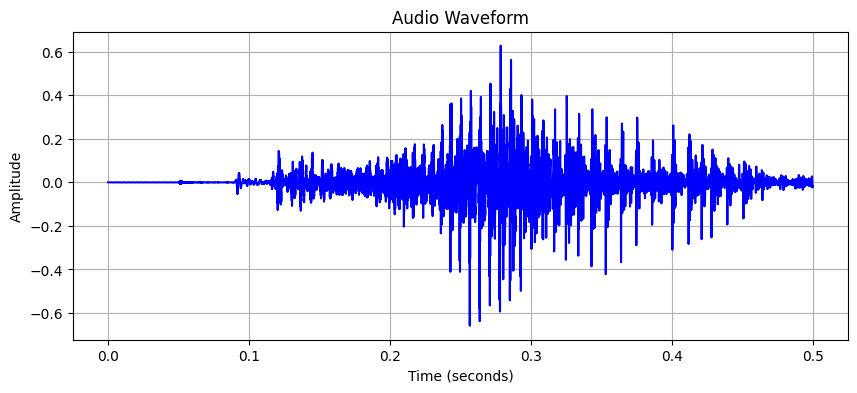

In [ ]:
# Create a time axis based on the length of the audio data
time_axis = np.arange(0, len(audio)) / sample_rate  # Assuming 'sample_rate' is known

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(time_axis, audio, color='b')
plt.title('Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

Normalisation

In [ ]:
# Find the peak amplitude in the audio array
peak_amplitude = np.max(np.abs(audio))

# Step 2: Calculate the normalization gain to target a specific peak level
target_peak_level = -1  # Replace with your desired peak level (e.g., -1 dBFS)
gain = target_peak_level / peak_amplitude

# Step 3: Apply the gain to normalize the audio array
normalized_audio = audio * gain

# Ensure that no samples exceed the range [-1, 1] (optional)
normalized_audio = np.clip(normalized_audio, -1, 1)

Now we plot the normalised waveform

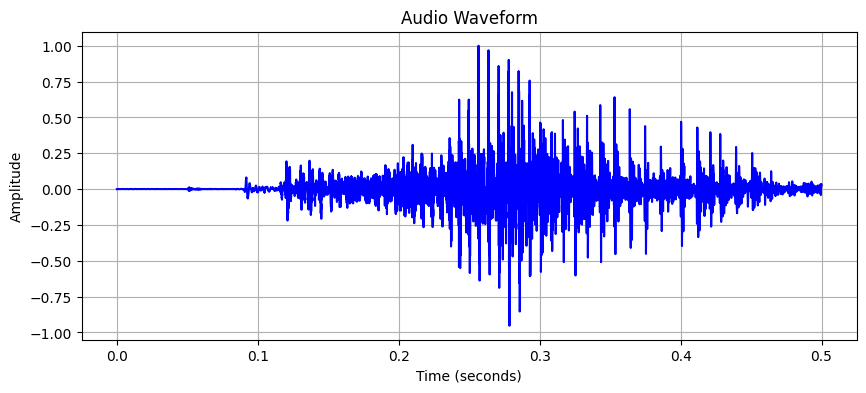

In [ ]:
# Create a time axis based on the length of the audio data
time_axis = np.arange(0, len(normalized_audio)) / sample_rate  # Assuming 'sample_rate' is known

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(time_axis, normalized_audio, color='b')
plt.title('Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

Listen to the audio example, what's the class?

In [ ]:
# TO DO
from IPython.display import Audio
Audio(y, rate=8000)

Decide on a window size for your STFT, the hop length and the number of mels you'll use to create your spectrogram.

In [ ]:
n_fft= 1024# TO DO
hop_length = 128# TO DO
n_mels = 128 # TO DO

Create a mel spectrogram using your hyper parameters from the previous cell

In [ ]:
S =librosa.feature.melspectrogram( y=audio, sr=8000,  n_fft=n_fft, hop_length=hop_length,n_mels=128)# TO DO

Visualise the mel spectrogram. Print out the corresponding value from `y` (targets).

If your spectrogram doesn't look like mine, or you're getting stuck, take a look at [this example](https://librosa.org/doc/0.10.1/generated/librosa.feature.melspectrogram.html#librosa-feature-melspectrogram)

4


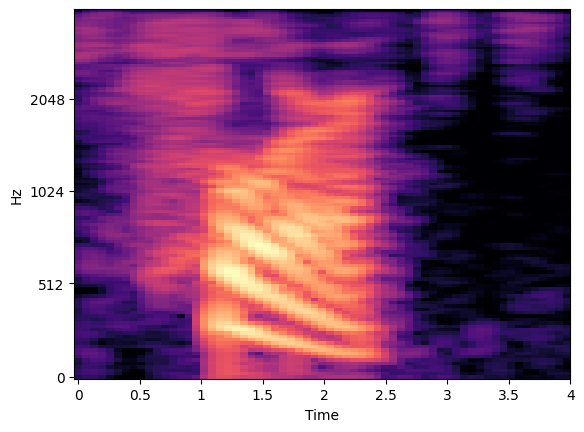

In [ ]:
S_dB = # TO DO

Create a function that will convert a single audio example to a spectrogram by using the above code. The function's definition should be this:
`convert_single_to_image(audio, n_fft, hop_length, n_mels)`

In [ ]:
def convert_single_to_image(audio, n_fft, hop_length, n_mels):

    # TO DO

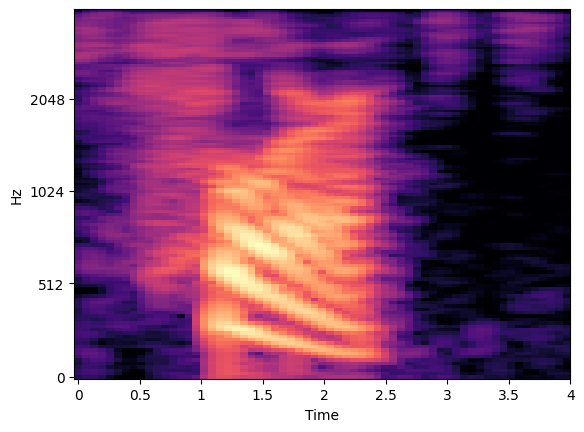

In [ ]:
spec = convert_single_to_image(audio,n_fft, hop_length, n_mels)
librosa.display.specshow(spec, x_axis='time',
                         y_axis='mel', sr=8000)

Create a function that will convert multiple audio examples into their corresponding spectrogams. This function should call the one you just created. The function's definition should be this: `convert_all_to_image(segments, n_fft, hop_length, n_mels)`

In [ ]:
def convert_all_to_image(segments, n_fft, hop_length, n_mels):
    # TO DO

Create a function that will take in multiple spectrograms and add another dimension so that Tensorflow knows the depth of the data.

The definition of this function should be: `add_extra_dim(spectrograms)`

In [ ]:
def add_extra_dim(spectrograms):
    # TO DO


Now convert all your audio data stored in variable `X` using the newly created functions.

The dimension of the output should be: `(12908, 128, 63)` if you used these hyper-parameters:

```
n_fft = 1024
hop_length = 128
n_mels = 128
```

In [ ]:
# This can take some time, about two minutes.
X = convert_all_to_image(X, n_fft, hop_length, n_mels)
X = add_extra_dim(X)

In [ ]:
X.shape
# In my case it was: (12908, 128, 63, 1)

(12908, 128, 63, 1)

At this point we have our dataset. We've mixed our classes with random segments from the background class.

## Some extra pre-processing

In [ ]:
np.unique(y)
# Expected output: array([0, 1, 2, 3, 4, 5])

array([0, 1, 2, 3, 4, 5])

In [ ]:
y = keras.utils.to_categorical(y)

This should be:
```
(12908, 128, 63, 1)
(12908, 6)
```

In [ ]:
print(X.shape)
print(y.shape)

(12908, 128, 63, 1)
(12908, 6)


Split into training and testing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

Create a 2D CNN

In [ ]:
# TO DO
model = Model(inputs, outputs)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 63, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 60, 32)       544       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 59, 27, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 13, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 10, 128)       1312

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(X_train, y_train ,epochs=5, validation_split=0.2, batch_size=32)

Epoch 1/5
259/259 [==============================] - 14s 14ms/step - loss: 1.2525 - accuracy: 0.5776 - val_loss: 0.7376 - val_accuracy: 0.7270
Epoch 2/5
259/259 [==============================] - 3s 13ms/step - loss: 0.4889 - accuracy: 0.8287 - val_loss: 0.3918 - val_accuracy: 0.8761
Epoch 3/5
259/259 [==============================] - 3s 12ms/step - loss: 0.2816 - accuracy: 0.9021 - val_loss: 0.5461 - val_accuracy: 0.8325
Epoch 4/5
259/259 [==============================] - 3s 11ms/step - loss: 0.2303 - accuracy: 0.9186 - val_loss: 0.2873 - val_accuracy: 0.9056
Epoch 5/5
259/259 [==============================] - 3s 11ms/step - loss: 0.1796 - accuracy: 0.9400 - val_loss: 0.3236 - val_accuracy: 0.8930


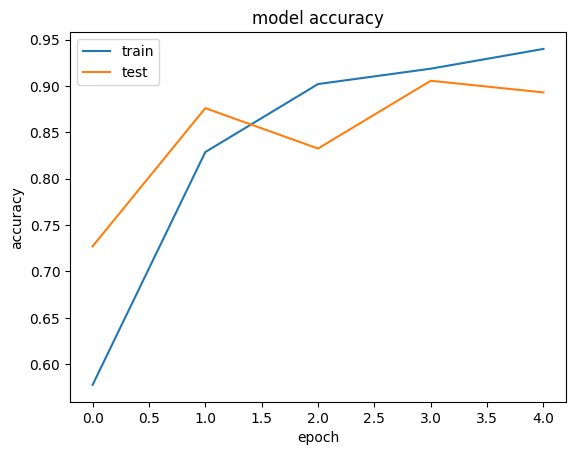

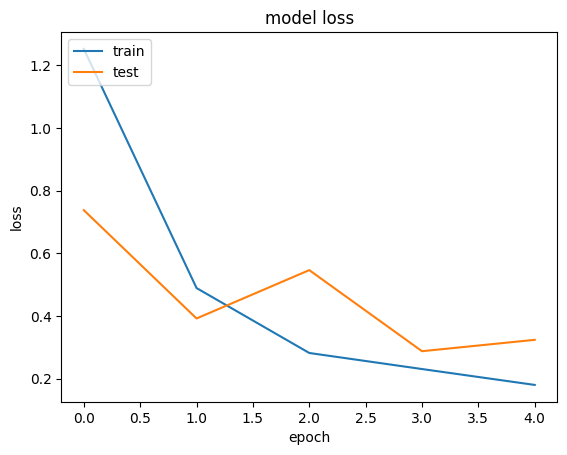

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

81/81 [==============================] - 1s 8ms/step - loss: 0.3130 - accuracy: 0.8974


[0.3129851222038269, 0.8973664045333862]

## Task:

* Try to incorporate additional augmentation techniques and explore other layers like 2D global pooling instead of a flattening layer.